In [1]:
# import astroquery
from astropy.coordinates import SkyCoord
import astropy.units as u
# from astroquery.simbad import Simbad
# from astroquery.vizier import Vizier
# from astroquery.ned import Ned
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import aplpy
from astropy.wcs import WCS
from astropy.coordinates import Angle
import astroalign as aa
from astropy.modeling.projections import Pix2Sky_Gnomonic, Sky2Pix_Gnomonic
from astropy.visualization import ZScaleInterval

In [2]:
aa.__version__

'2.4'

In [3]:
# Reference image
refpath = "./wcstestdata/IC2143_wcs.fits"
hdulist = fits.open(refpath)

INFO: Auto-setting vmin to  1.285e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.729e+02 [aplpy.core]


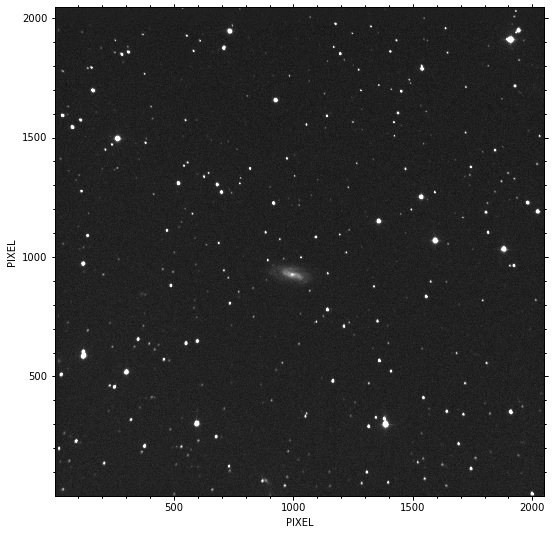

In [4]:
refimg = hdulist[0].data
fig = aplpy.FITSFigure(refimg)
fig.show_grayscale()
plt.show()

In [5]:
h, w = refimg.shape
refwcs = WCS(hdulist[0])
cra, cdec = refwcs.all_pix2world([[w/2, h/2]], 0, ra_dec_order=True)[0]

# Get sources with GAIA

In [6]:
# point = SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')
frame_center = SkyCoord(cra, cdec, unit='deg')
fov_rad = 10 * u.arcminute

In [7]:
MAX_REF_STARS = 5
q = Gaia.cone_search_async(frame_center, fov_rad)
result_table = q.get_results()
result_table.sort("phot_g_mean_mag")
result_table = result_table[:MAX_REF_STARS]

INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
# Flatten RA, Dec into list of bare degree numbers
ra_refobjs = [Angle(ra, unit="degree").degree for ra in result_table["ra"]]
dec_refobjs = [Angle(dec, unit="degree").degree for dec in result_table["dec"]]

INFO: Auto-setting vmin to  1.332e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.217e+02 [aplpy.core]


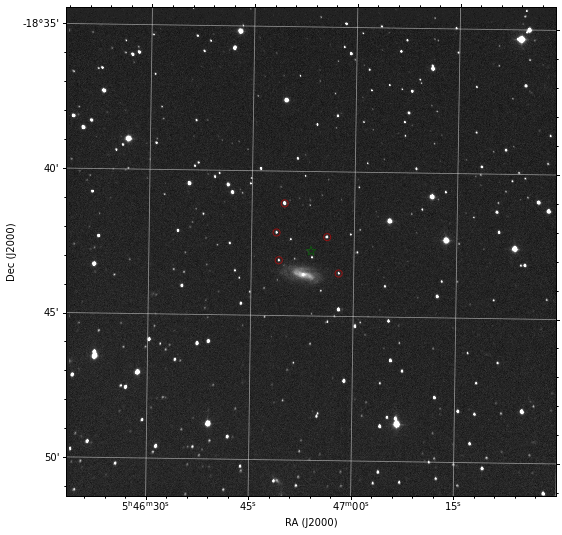

In [9]:
fig = aplpy.FITSFigure(hdulist[0])
fig.show_grayscale()
fig.add_grid()
fig.show_markers(ra_refobjs, dec_refobjs, layer='marker_set_1', edgecolor='red',
                facecolor='none', marker='o', s=50, alpha=0.5)
fig.show_markers(frame_center.ra.degree, frame_center.dec.degree, layer='marker_set_2', edgecolor='green',
                facecolor='none', marker='*', s=100, alpha=0.5)
plt.show()

# Gnomonic projection

In [116]:
def arg(x, y):
    return np.rad2deg(np.arcsin(y / np.sqrt(x * x + y * y)))

def xy(phi, theta):
    r0 = 180. / np.pi
    phirad = np.deg2rad(phi)
    thetarad = np.deg2rad(theta)
    x = r0 * np.sin(phirad) / np.tan(thetarad)
    y = r0 * np.cos(phirad) / np.tan(thetarad)
    return x, y

def phitheta(x, y):
    r0inv = np.pi / 180.
    phideg = arg(-y, x)
    thetadeg = arg(r0inv * np.sqrt(x * x + y * y), 1)
    return phideg, thetadeg

In [119]:
xy(*phitheta(3., 1.)), phitheta(*xy(3., 1.))

((3.0000000000000795, 1.0000000000000266),
 (3.0000000000000004, 1.0000000000000002))

In [122]:
Sky2Pix_Gnomonic.evaluate(*Pix2Sky_Gnomonic.evaluate([3.], [1.]))

(array([3.]), array([1.]))

In [121]:
Pix2Sky_Gnomonic.evaluate(*Sky2Pix_Gnomonic.evaluate([3.], [1.]))

(array([3.]), array([1.]))

# Continue with the problem

In [28]:
xs, ys = Sky2Pix_Gnomonic.evaluate(ra_refobjs, dec_refobjs)

INFO: Auto-setting vmin to  1.257e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.038e+02 [aplpy.core]


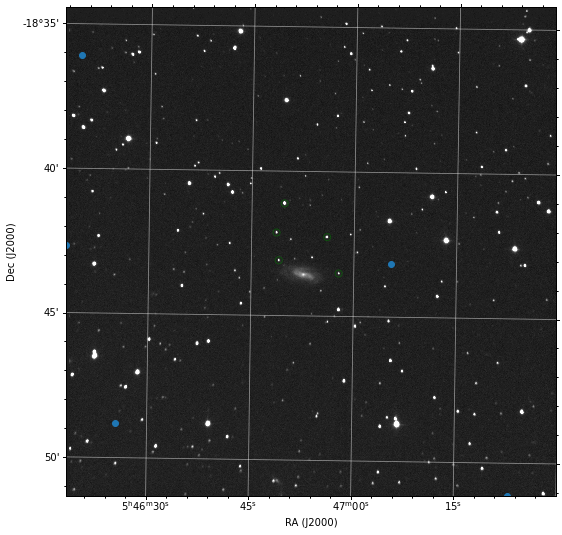

In [17]:
# # This is to show that the gnomonic projection sort of resembles the sources on the image

min_xs, max_xs = np.min(xs), np.max(xs)
min_ys, max_ys = np.min(ys), np.max(ys)

dx = max_xs - min_xs
dy = max_ys - min_ys

fig = aplpy.FITSFigure(hdulist[0])
fig.show_grayscale()
fig.add_grid()

img_max_h = refimg.shape[0] * 0.9
img_max_w = refimg.shape[1] * 0.9

plt.scatter(-(ys - min_ys) * img_max_h / dy + img_max_h,
            -(xs - min_xs) * img_max_w / dx + img_max_w,
            alpha=1, marker="o")
# fig.show_markers((xs - np.min(xs)) * refimg.shape[1] / dx, (ys - np.min(ys)) * refimg.shape[0] / dy,
#                 layer='marker_set_1', edgecolor='red',
#                 facecolor='none', marker='o', s=50, alpha=0.5)

fig.show_markers(ra_refobjs, dec_refobjs, layer='marker_set_2', edgecolor='green',
                facecolor='none', marker='o', s=50, alpha=0.5)
plt.show()

In [15]:
xys = np.array([*zip(xs, ys)]) # x,y pairs as required by aa
t, (source, target) = aa.find_transform(refimg, xys)

In [134]:
t.rotation, t.translation, t.scale

(-1.9983895585421259,
 array([-168.93626326,    9.7035672 ]),
 9.582696970254248e-06)

In [150]:
t.inverse(xys)

array([[  6107.09878813, -20234.72299368],
       [ -1430.78531639,  -4805.31052992],
       [  1034.53334384,  21333.53464256],
       [  6616.70977511,    778.83497279],
       [ -6837.74503098,  10514.40197105]])

In [151]:
xys

array([[-169.1369769 ,    9.73072187],
       [-168.97247963,    9.73513875],
       [-168.75434728,    9.60977155],
       [-168.95576517,    9.64277502],
       [-168.81740675,    9.72141004]])

In [152]:
aa.matrix_transform([[6107.09878813, -20234.72299368]], t.params)

array([[-169.1369769 ,    9.73072187]])